In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# os.environ['PRJ'] = "/Users/ymohit/skigp/"

import numpy as np
import fastmat as fm
from scipy.sparse import coo_matrix

# Viz specific 
import warnings
import matplotlib.cbook
# import seaborn as sns
# sns.set()


import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import pyplot as plt
from IPython.core.display import  HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

def allclosef(a1, a2):
    print("Max difference: %.4e" % (np.max(np.abs(a1 - a2))))

In [2]:
from fkigp.cgvariants import cg
from fkigp.gps.gpbase import NoiseCovar
from fkigp.gps.kernels import RBFKernel, ScaleKernel, GridKernel

from fkigp.gridutils import grid_coords, grid_points, get_basis
from fkigp.gps.gpoperators import KroneckerToeplitzMatVec, KissGpLinearOperator

# Just to match gpytorch's RBF kernel 
import torch
import gpytorch

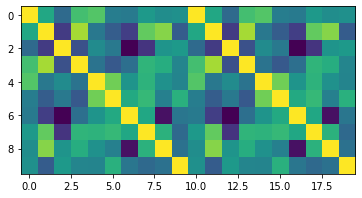

In [3]:
## Testing scale kernel 

# RBF kernel without scale kernel 
x = np.random.rand(10, 5)
c1 = RBFKernel()
cov1 = c1(x)

c2 = ScaleKernel(RBFKernel())
cov2 = c2(x)
plt.imshow(np.hstack([cov1, cov2]))  ## horizontally stacked ...
plt.show()

assert sum(sum(np.abs(np.divide(cov1, cov2) - np.ones_like(cov1)))) == 0

In [4]:
## Matching the RBF kernel for 1-D

grid = [(1.0, 60, 8)]
points = grid_coords(grid)[0]
t_grid = torch.tensor(points)


np_rbf = RBFKernel()
gp_rbf = gpytorch.kernels.RBFKernel()

np.testing.assert_almost_equal(np_rbf(points), gp_rbf(t_grid).evaluate().detach().numpy())

np_rbf.lengthscale = 10
gp_rbf.lengthscale = 10

rbf_mat1 = np_rbf(points)
rbf_mat2 = gp_rbf(t_grid).evaluate().detach().numpy()

np.testing.assert_almost_equal(np_rbf(points), gp_rbf(t_grid).evaluate().detach().numpy())

In [5]:
## Matching the RBF kernel for 2-D

grid = [(-1, 1, 80), (-5, 4, 16)]
enum_grid = grid_points(grid)

t_grid = torch.tensor(enum_grid)


np_rbf = RBFKernel()
gp_rbf = gpytorch.kernels.RBFKernel()
gp_rbf.lengthscale = 1

np.testing.assert_almost_equal(np_rbf(enum_grid), gp_rbf(t_grid).evaluate().detach().numpy())

np_rbf.lengthscale = 10
gp_rbf.lengthscale = 10

rbf_mat1 = np_rbf(enum_grid)
rbf_mat2 = gp_rbf(t_grid).evaluate().detach().numpy()

np.testing.assert_almost_equal(np_rbf(enum_grid), gp_rbf(t_grid).evaluate().detach().numpy()) 

Grid kernel matrix from Gpytorch grid interpolation kernel (computed using Kron):


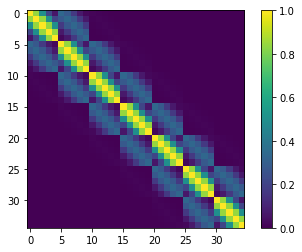

Grid kernel matrix from our numpy RBF kernel (computed without Kron):


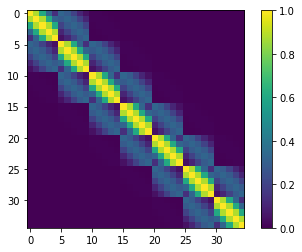

Grid kernel matrix from our numpy RBF kernel (computed using Kron):


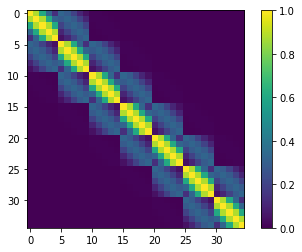

In [6]:
## Visualizing grid kernel from gpytorch grid interpolation kernel 

grid_sizes = [5, 7]
grid_bounds = tuple([(-1, 1), (-5, 4)])
gp_rbf = gpytorch.kernels.RBFKernel(ard_num_dims=len(grid))
gp_rbf.lengthscale = np.sqrt(2)  ## this is because we have a scalar difference from Gpytorch kernel definition 

gp_ski = gpytorch.kernels.GridInterpolationKernel(gp_rbf, grid_sizes, len(grid_bounds), grid_bounds)
gp_kmat = gp_ski._inducing_forward(False).evaluate().detach().numpy()

print("Grid kernel matrix from Gpytorch grid interpolation kernel (computed using Kron):")
plt.imshow(gp_kmat)
plt.colorbar()
plt.show()



grid = [(-1, 1, 5), (-5, 4, 7)]
enum_grid = grid_points(grid)

np_rbf = RBFKernel()
np_rbf.lengthscale=1
rbf_mat = np_rbf(enum_grid)

grid_kernel = GridKernel(RBFKernel(ard_num_dims=len(grid)), grid, dtype=enum_grid.dtype)


# Test
np.testing.assert_almost_equal(rbf_mat, grid_kernel.forward(x1=None, is_kron=True).getArray().real)

print("Grid kernel matrix from our numpy RBF kernel (computed without Kron):")
plt.imshow(rbf_mat)
plt.colorbar()
plt.show()


print("Grid kernel matrix from our numpy RBF kernel (computed using Kron):")
plt.imshow(grid_kernel.forward(x1=None, is_kron=True).getArray().real)
plt.colorbar()
plt.show()

In [7]:
## Testing basic kernel MVMs with fastmat using Kronecker-Toeplitz structure

grid = [(-5, +5, 3), (-2, +2, 2), (-2, +1, 2)]

grid_kernel = GridKernel(RBFKernel(ard_num_dims=len(grid)), grid, dtype=enum_grid.dtype)

enum_grid = grid_points(grid)

np_rbf = RBFKernel()
rbf_mat = np_rbf(enum_grid)

grid_size = np.prod([i[-1] for i in grid])
kmm_in = grid_kernel.forward(x1=None)

kmm = KroneckerToeplitzMatVec(kmm_in, shape=(grid_size,grid_size), dtype=enum_grid.dtype)

num_vecs = 100
for i in range(num_vecs):
    vec = np.random.rand(grid_size, 1)
    np.testing.assert_almost_equal(kmm.kmm_matvec(vec), np.matmul(rbf_mat, vec), decimal=3)

In [8]:
## Sparse matrix vector multipication 

row  = np.array([0, 3, 1, 0])
col  = np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])

sparse_mat = coo_matrix((data, (row, col)), shape=(4, 4))
matrix  = coo_matrix((data, (row, col)), shape=(4, 4)).toarray()


for i in range(100):
    vec = np.random.rand(4, 1)
    np.testing.assert_almost_equal(np.matmul(matrix, vec), sparse_mat.dot(vec))

In [9]:
# Testing diagonal noise matrix
noise_covar = NoiseCovar(10, 0.01)

print(noise_covar().getArray())

print(noise_covar(shape=5).getArray()) ## we can get other sizes as well

[[1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04]]
[[1.e-04 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-04 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-04 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-04]]
